In [1]:
import matplotlib
import matplotlib.pyplot as plt
import gzip, pickle
import seaborn as sn
import pandas as pd
import riem_funcs
from riem_funcs import *
import scipy.linalg as linalg
import sklearn.cluster

In [2]:
matplotlib.__version__

'3.3.2'

In [80]:
rois =  ['lamygdala', 'lanteriorinsula', 'lcuneus', 'lfrontaleyefield', 'linferiorfrontallobe',
                     'linferiorparietallobe', 'lmidfrontalgyrus', 'lparahippocampus', 'lposteriorintraparietalsulcus',
                     'lprimaryauditorycortex', 'lprimaryvisualcortex', 'lsuperioroccipitallobe',
                     'lsuperiortemporaljunction', 'lsuperiortemporalsulcus', 'lventralintraparietalsulcus',
                     'medialprefrontalcortex', 'posteriorcingulatecortex', 'precuneus', 'ramygdala', 'ranteriorinsula',
                     'rcuneus', 'rfrontaleyefield', 'rinferiorfrontallobe', 'rinferiorparietallobe', 'rmidfrontalgyrus',
                     'rparahippocampus', 'rposteriorintraparietalsulcus', 'rprimaryauditorycortex',
                     'rprimaryvisualcortex', 'rsuperioroccipitallobe', 'rsuperiortemporaljunction',
                     'rsuperiortemporalsulcus', 'rventralintraparietalsulcus']

## Create result directories

In [3]:
try:
    os.mkdir('RiemannResults')
except FileExistsError:
    pass

In [4]:
data_dir = 'data'+os.sep

## Pull the data and metadata files

In [5]:
meta_dir = 'metadata'+os.sep
valid_runs_uiuc = pd.read_csv(meta_dir + 'UIUC_valid_runs.csv',index_col='ID',header=0,names=['ID','A','B','C','D','E','F','G'],usecols=['ID','A','B'])
valid_runs_whasc = pd.read_csv(meta_dir + 'WHASC_valid_runs.csv',index_col='ID',header=0,names=['ID','A','B','C','D'],usecols=['ID','A','B'])

valid_runs_dict_uiuc = {re.sub(r'\d+_','',idx.rstrip('*')): row.values for idx,row in valid_runs_uiuc.iterrows()}
valid_runs_dict_whasc = {re.sub(r'\d+_','',idx.rstrip('*')): row.values for idx,row in valid_runs_whasc.iterrows()}

metadata_uiuc = pd.read_csv(meta_dir + 'UIUC_metadata.csv',index_col = 'ID')
metadata_whasc = pd.read_csv(meta_dir + 'WHASC_metadata.csv',index_col = 'ID')

uiuc_files = [data_dir+'UIUC'+os.sep+fname for fname in os.listdir(data_dir+'UIUC') if not fname.startswith('.')]
whasc_files = [data_dir+'WHASC'+os.sep+fname for fname in os.listdir(data_dir+'WHASC') if not fname.startswith('.')]

In [40]:
metadata_uiuc

,Group,Location,Gender,Age,Onset_duration,Khalfa,BDI_A,BDI_B,BAI_A,BAI_B,TFI_A,TFI_B,TPFQ_A,TPFQ_B
ID,,,,,,,,,,,,,,
113,0,0,F,37.0,0.0,24.0,2.0,2.0,6.0,4.0,0.0,0.0,0.00,0.00
115,0,0,F,48.0,0.0,10.0,0.0,0.0,5.9,5.9,0.0,0.0,0.00,0.00
117,0,0,M,25.0,0.0,4.0,19.0,21.0,3.0,2.0,0.0,0.0,0.00,0.00
120,0,0,F,59.0,0.0,14.0,21.0,13.0,3.0,5.0,0.0,0.0,0.00,0.00
122,0,0,F,60.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,11,0,M,43.0,276.0,46.0,8.0,5.0,0.0,9.0,31.6,31.6,37.50,19.00
279,11,0,M,61.0,216.0,0.0,4.0,5.0,5.0,2.0,10.8,11.2,1.65,0.50
280,11,0,M,45.0,180.0,33.0,7.0,4.0,0.0,0.0,20.0,17.6,21.50,17.50


## Annotate each time series with the appropriate labels

In [162]:
uiuc_samples = []
count =0
for fname_prefix in uiuc_files:
    runs = [run for run in os.listdir(fname_prefix) if run.startswith('run') and not(fname_prefix.endswith('B') and 
                                                                                     (run.endswith('1') or run.endswith('2')))]
    for run in runs:
        count += 1
        ID = re.findall(r'\d+_(\d+)_',fname_prefix)[0]
        Group_binary = re.findall(r'(\d+)_\d+_',fname_prefix)[0][1:]
        if Group_binary == "00":
            Group = 'ctr'
        if Group_binary == "01":
            Group = 'hl'
        if Group_binary == "10":
            Group = 'tin'
        if Group_binary == "11":
            Group = 'tin_hl'
        
        filename = "ROI_matrix_data_33.csv"
        try:
            timeSeries = np.genfromtxt(fname_prefix+os.sep+run+os.sep+filename,delimiter=',')
        except OSError:
            continue
            
        if timeSeries.shape == (33,300):
            uiuc_samples.append({'TimeSeries':timeSeries,'Location':'chm','Run':run,'ID':ID,'Group':Group,
                                 'TFI':metadata_uiuc.loc[int(ID),'TFI_A']})          

C:\Users\danie\anaconda3\envs\Neuro\lib\site-packages\ipykernel_launcher.py:21: UserWarning: genfromtxt: Empty input file: "data\UIUC\Fh_001_285_B\run5\ROI_matrix_data_33.csv"


In [163]:
whasc_samples = []
for fname_prefix in whasc_files:
    runs = [run for run in os.listdir(fname_prefix) if run.startswith('run') and not(fname_prefix.endswith('B') and 
                                                                                     (run.endswith('1') or run.endswith('2')))]
    for run in runs:
        ID = re.findall(r'\d+_(\d+)_',fname_prefix)[0]
        Group_binary = re.findall(r'(\d+)_\d+_',fname_prefix)[0][1:]
        if Group_binary == "00":
            Group = 'ctr'
        if Group_binary == "01":
            Group = 'hl'
        if Group_binary == "10":
            Group = 'tin'
        if Group_binary == "11":
            Group = 'tin_hl'
        filename = "ROI_matrix_data_33.csv"
        timeSeries = np.genfromtxt(fname_prefix+os.sep+run+os.sep+filename,delimiter=',')
        
        whasc_samples.append({'TimeSeries':timeSeries,'Location':'san','Run':run,'ID':ID,'Group':Group,
                             'TFI':metadata_whasc.loc[int(ID),'TFI_A']})

## Visualize the data before and after the tangent space projection

In [164]:
data = {'samples':uiuc_samples+whasc_samples}
X = np.array([sample['TimeSeries'] for sample in data['samples']]) #if data_selector(sample,valid_runs_dict_uiuc,valid_runs_dict_whasc)])  
y = np.array([get_label_8(sample['Group'],sample['Location']) for sample in data['samples']])# if data_selector(sample,valid_runs_dict_uiuc,valid_runs_dict_whasc)])
covest = Covariances()
ts = TangentSpace()
to_mat= to_symm_mat(0,33)
transformer = make_pipeline(covest,ts,to_mat)
covs = covest.fit_transform(X)
transformed = transformer.fit_transform(X)

class_indices = [[ind for ind,x in enumerate(y) if x == j] for j in range(0,8)]
class_list = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','hl_tin_chm','hl_tin_san','tin_chm','tin_san']

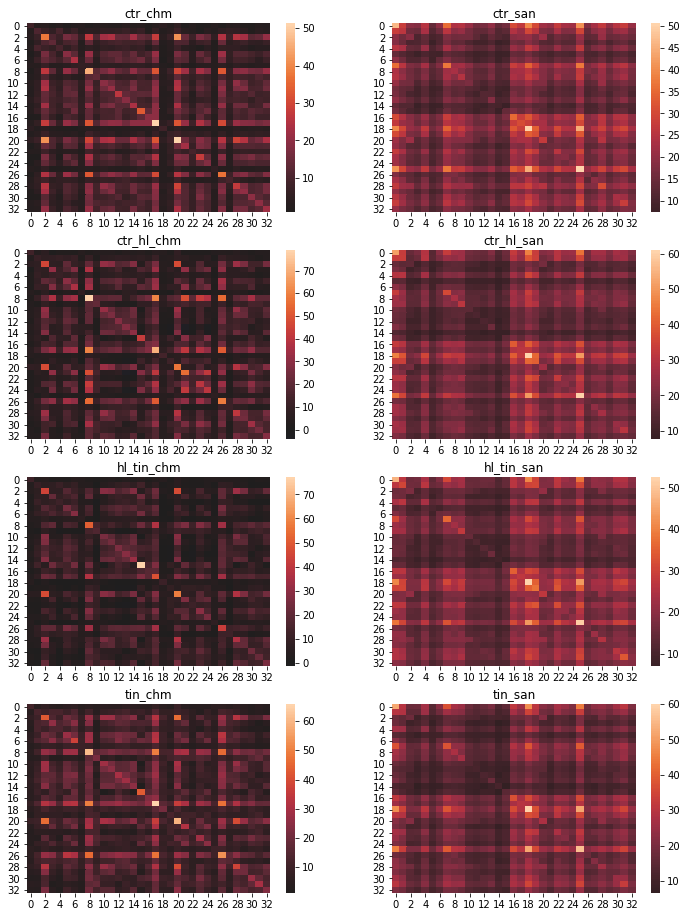

In [167]:
fig,axs = plt.subplots(4,2,figsize=(12,16))
for cls,ind_list in enumerate(class_indices):
    mean = np.mean([covs[i] for i in ind_list],axis=0)
    axs[cls//2,cls%2].set_title(class_list[cls])
    sn.heatmap(mean,center=0,ax=axs[cls//2,cls%2])
plt.savefig('RiemannResults/AvgCovMat.png',bbox_inches='tight')

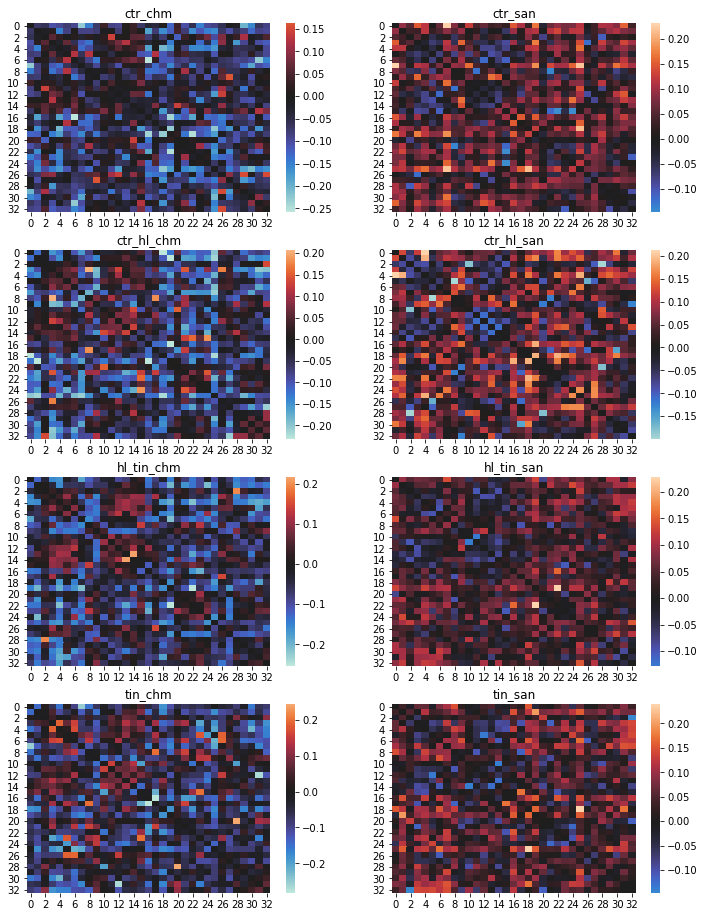

In [168]:
fig,axs = plt.subplots(4,2,figsize=(12,16))
for cls,ind_list in enumerate(class_indices):
    mean = np.mean([transformed[i] for i in ind_list],axis=0)
    axs[cls//2,cls%2].set_title(class_list[cls])
    sn.heatmap(mean-(mean*np.eye(mean.shape[0])),center=0,ax=axs[cls//2,cls%2])
plt.savefig('RiemannResults/AvgCovMatRiem.png',bbox_inches='tight')

### Use condition number to estimate collinearity before and after projection

In [169]:
X_cov = np.array([x[np.triu_indices(33,k=1)] for x in covs])
X_riem = np.array([x[np.triu_indices(33,k=1)] for x in transformed])
Z_cov = (X_cov - np.mean(X_cov, axis=0)) / np.std(X_cov, axis=0)
Z_riem = (X_riem - np.mean(X_riem, axis=0)) / np.std(X_riem, axis=0)

In [170]:
X_cov.shape

(475, 528)

In [171]:
print("Condition number before projection: " + str(np.linalg.cond(Z_cov.T @ Z_cov)))
print("Condition number after projection: " + str(np.linalg.cond(Z_riem.T @ Z_riem)))

Condition number before projection: 1.5545261033938444e+19
Condition number after projection: 2.354147119672325e+19


### Plot largest eigenvalues to see what kind of distribution they have before and after transition.

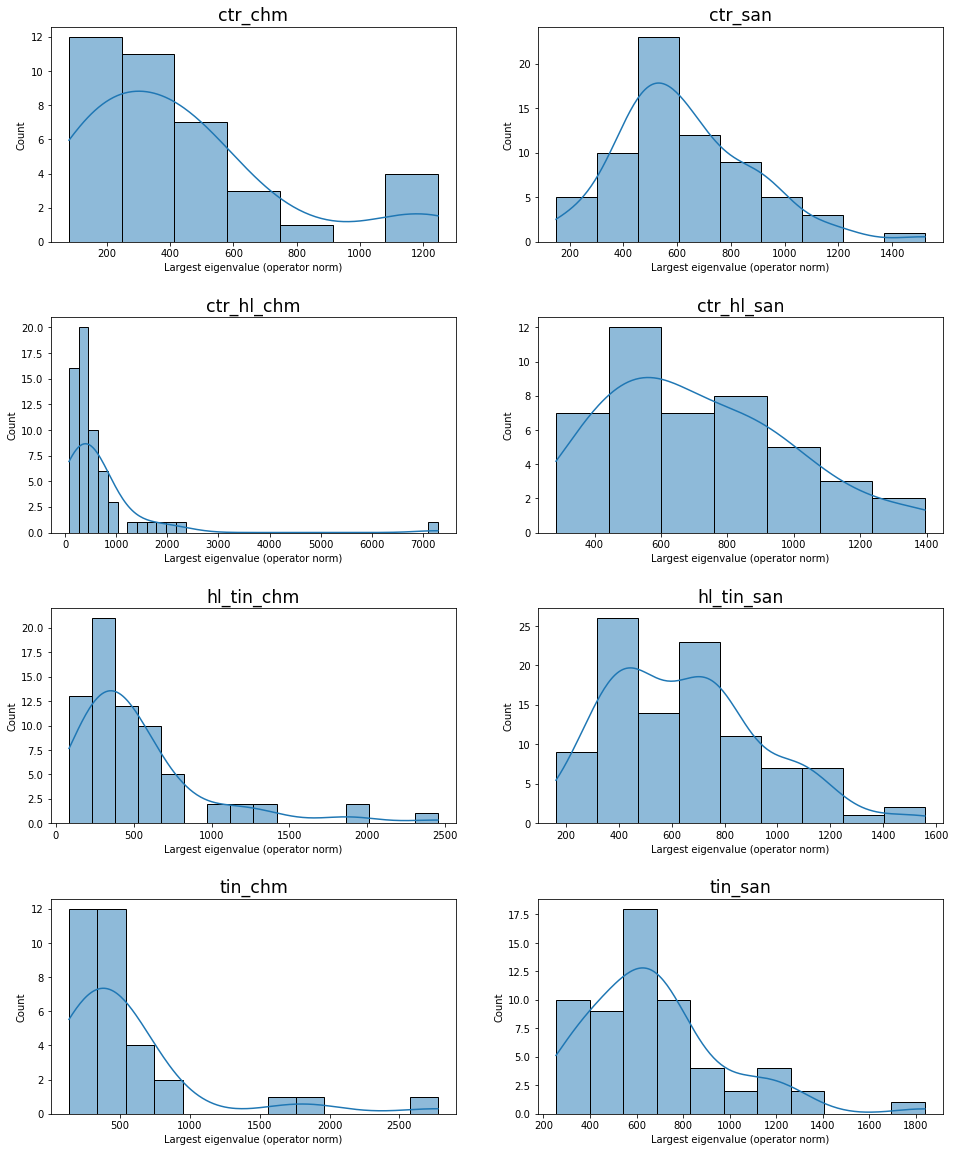

In [172]:
#before transition
fig,axs = plt.subplots(4,2,figsize=(16,20))
plt.subplots_adjust(hspace=0.35)
for cls,ind_list in enumerate(class_indices):
    #evals are 0-indexed
    which_eval = 0
    largest_evals = [linalg.eig(covs[i])[0][which_eval].real for i in ind_list if linalg.eig(covs[i])[0][0].real < 100000]
    axs[cls//2,cls%2].set_title(class_list[cls],fontsize='xx-large')
    sn.histplot(largest_evals,kde=True,ax=axs[cls//2,cls%2])
    #axs[cls//2,cls%2].set_xlim(0,2500)
    #axs[cls//2,cls%2].set_ylim(0,35)
    axs[cls//2,cls%2].set_xlabel('Largest eigenvalue (operator norm)')
plt.savefig('RiemannResults\\histcovs' + str(which_eval) + '.png',bbox_inches='tight')

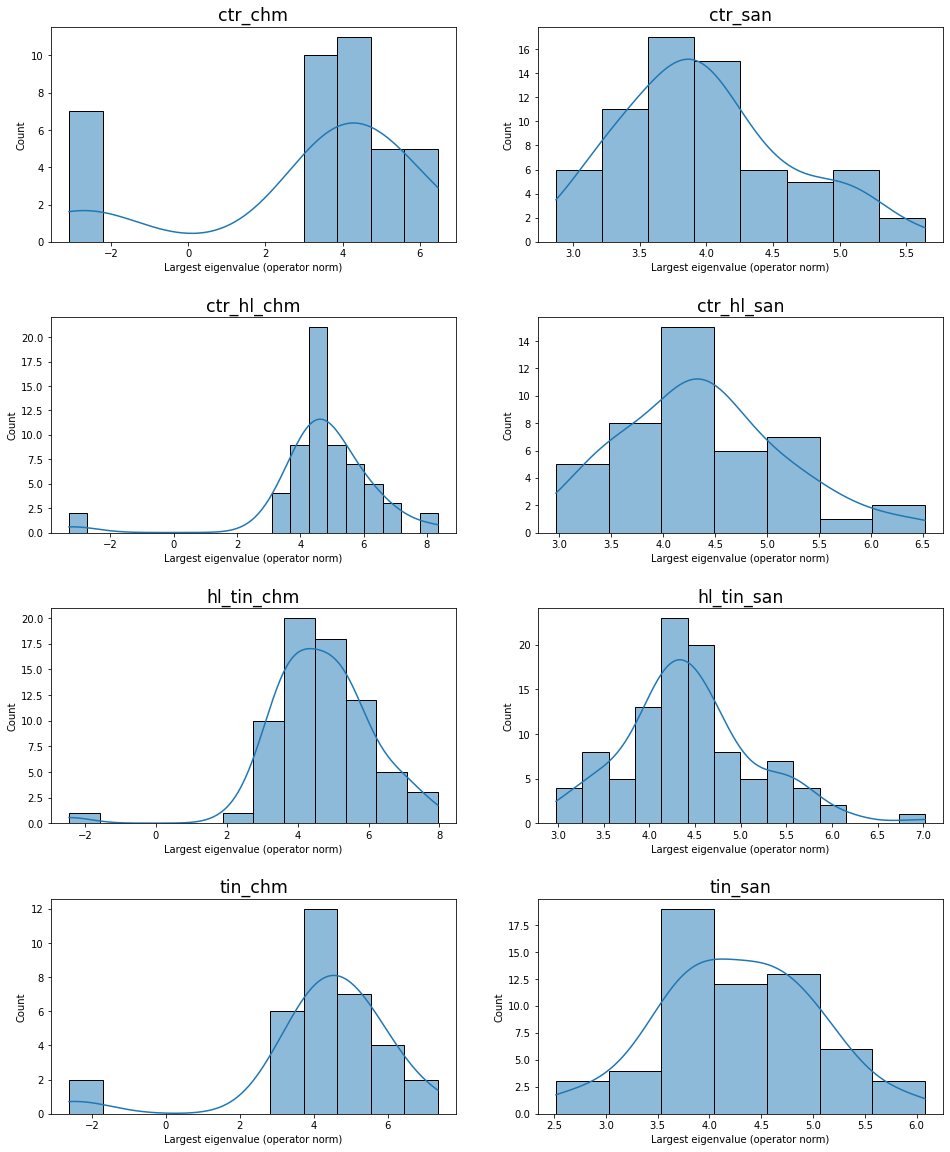

In [173]:
#After transition
fig,axs = plt.subplots(4,2,figsize=(16,20))
plt.subplots_adjust(hspace=0.35)
for cls,ind_list in enumerate(class_indices):
    #evals are 0-indexed
    which_eval = 0
    largest_evals = [linalg.eig(transformed[i])[0][which_eval].real for i in ind_list if linalg.eig(covs[i])[0][0].real < 100000]
    axs[cls//2,cls%2].set_title(class_list[cls],fontsize='xx-large')
    sn.histplot(largest_evals,kde=True,ax=axs[cls//2,cls%2])
    #axs[cls//2,cls%2].set_xlim(-4,10)
    #axs[cls//2,cls%2].set_ylim(0,30)
    axs[cls//2,cls%2].set_xlabel('Largest eigenvalue (operator norm)')
plt.savefig('RiemannResults\\histtransf' + str(which_eval) + '.png',bbox_inches='tight')

In [174]:
from pyriemann.utils.base import invsqrtm

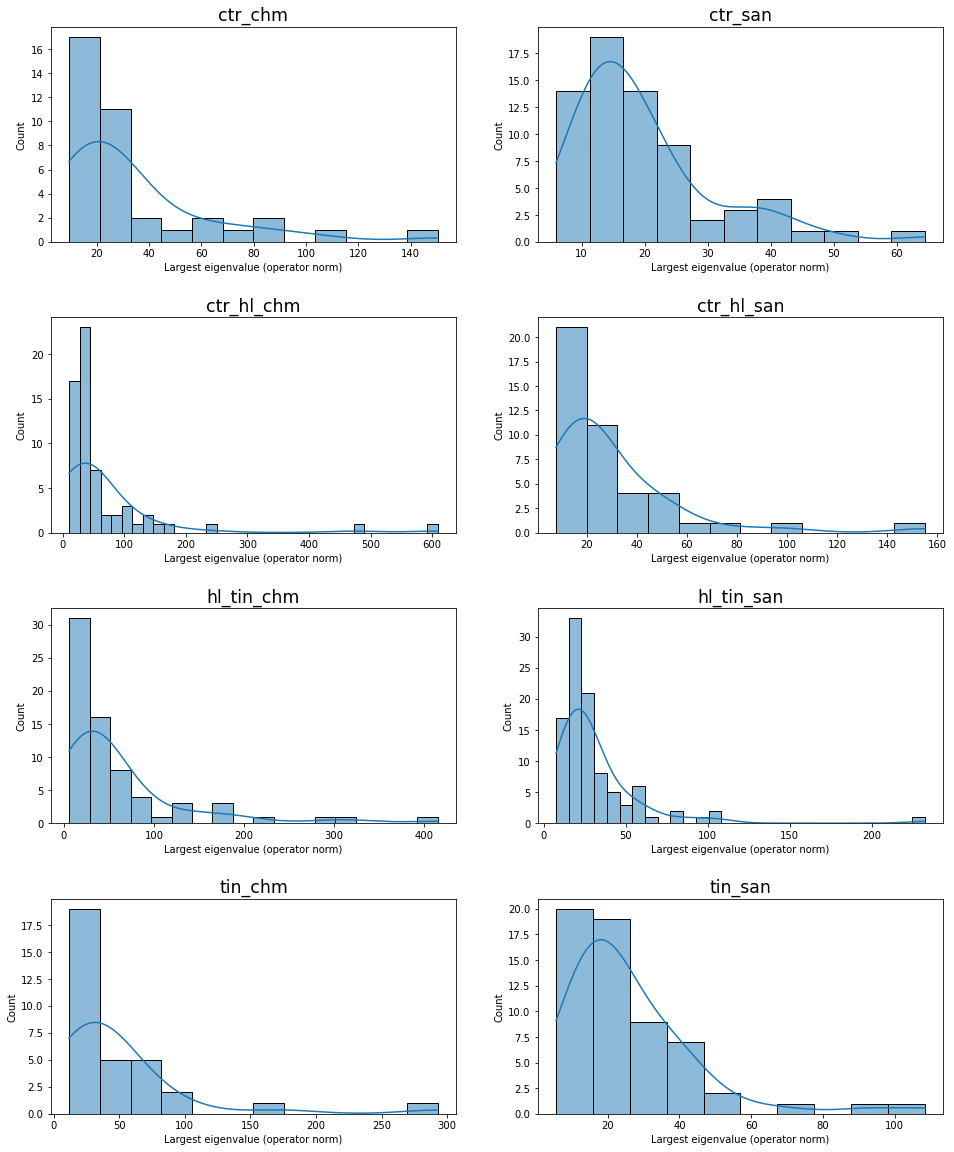

In [175]:
#Demeaned (half transition)
fig,axs = plt.subplots(4,2,figsize=(16,20))
plt.subplots_adjust(hspace=0.35)
frechet_mean = transformer[1].reference_
sqrtinv = invsqrtm(frechet_mean)
demeaned = [sqrtinv @ cov @ sqrtinv for cov in covs]
for cls,ind_list in enumerate(class_indices):
    #evals are 0-indexed
    which_eval = 0
    largest_evals = [linalg.eig(demeaned[i])[0][which_eval].real for i in ind_list
                     if linalg.eig(demeaned[i])[0][which_eval].real < 15000]
    axs[cls//2,cls%2].set_title(class_list[cls],fontsize='xx-large')
    sn.histplot(largest_evals,kde=True,ax=axs[cls//2,cls%2])
    #axs[cls//2,cls%2].set_xlim(0,2500)
    #axs[cls//2,cls%2].set_ylim(0,35)
    axs[cls//2,cls%2].set_xlabel('Largest eigenvalue (operator norm)')
plt.savefig('RiemannResults\\histcovsdem' + str(which_eval) + '.png',bbox_inches='tight')

### Scatter plots of pairs of evals before and after projection

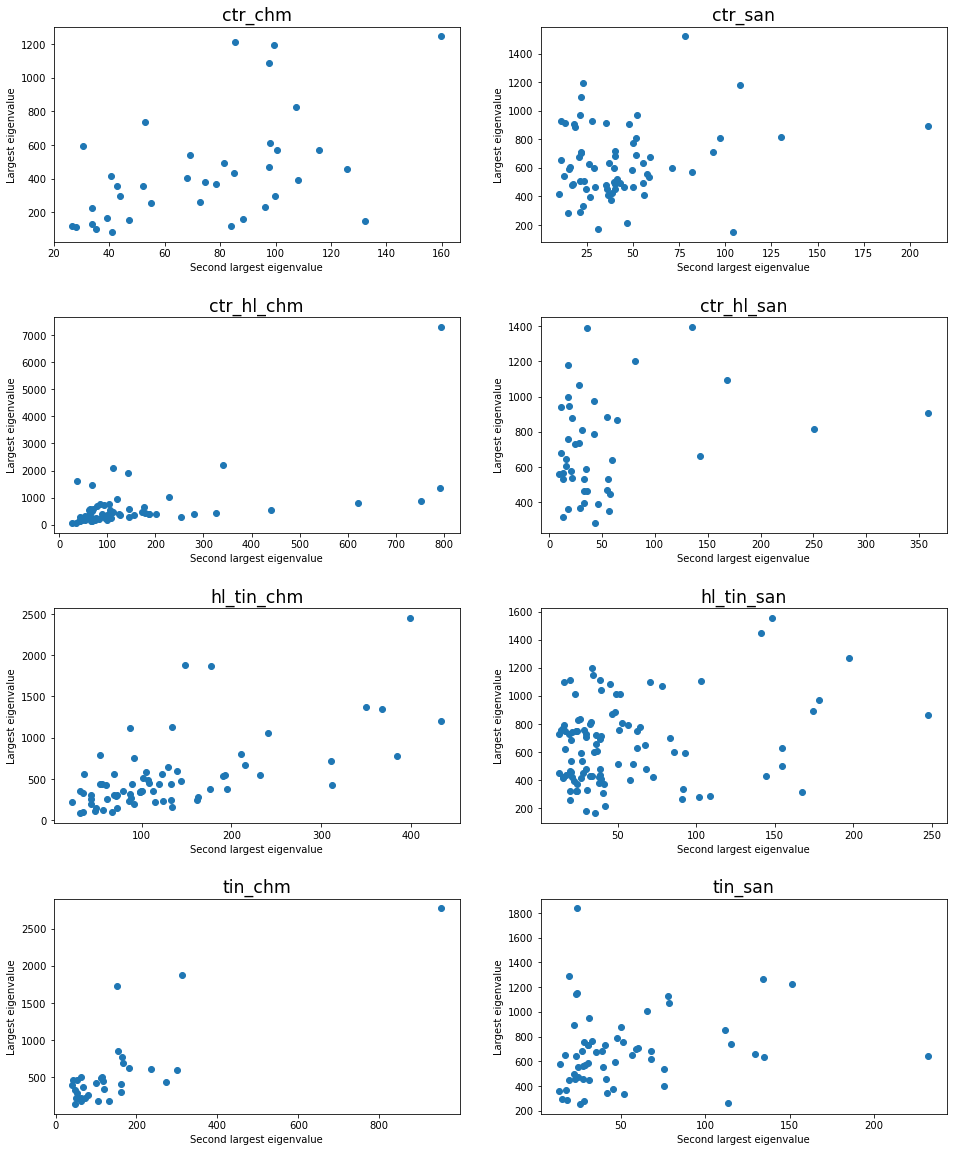

In [176]:
#largest vs second largest
fig,axs = plt.subplots(4,2,figsize=(16,20))
plt.subplots_adjust(hspace=0.35)
for cls,ind_list in enumerate(class_indices):
    #evals are 0-indexed
    which_eval = 0
    largest = []
    second_largest = []
    for i in ind_list:
        evals = linalg.eig(covs[i])[0]
        if evals[0].real < 100000:
            largest.append(evals[0].real)
            second_largest.append(evals[1].real)
    axs[cls//2,cls%2].set_title(class_list[cls],fontsize='xx-large')
    axs[cls//2,cls%2].scatter(second_largest,largest)
    #axs[cls//2,cls%2].set_xlim(0,2500)
    #axs[cls//2,cls%2].set_ylim(0,35)
    axs[cls//2,cls%2].set_xlabel('Second largest eigenvalue')
    axs[cls//2,cls%2].set_ylabel('Largest eigenvalue')
plt.savefig('RiemannResults\\compare_largest_evals_covs.png',bbox_inches='tight')

### Are the clusters due to music vs non-music?

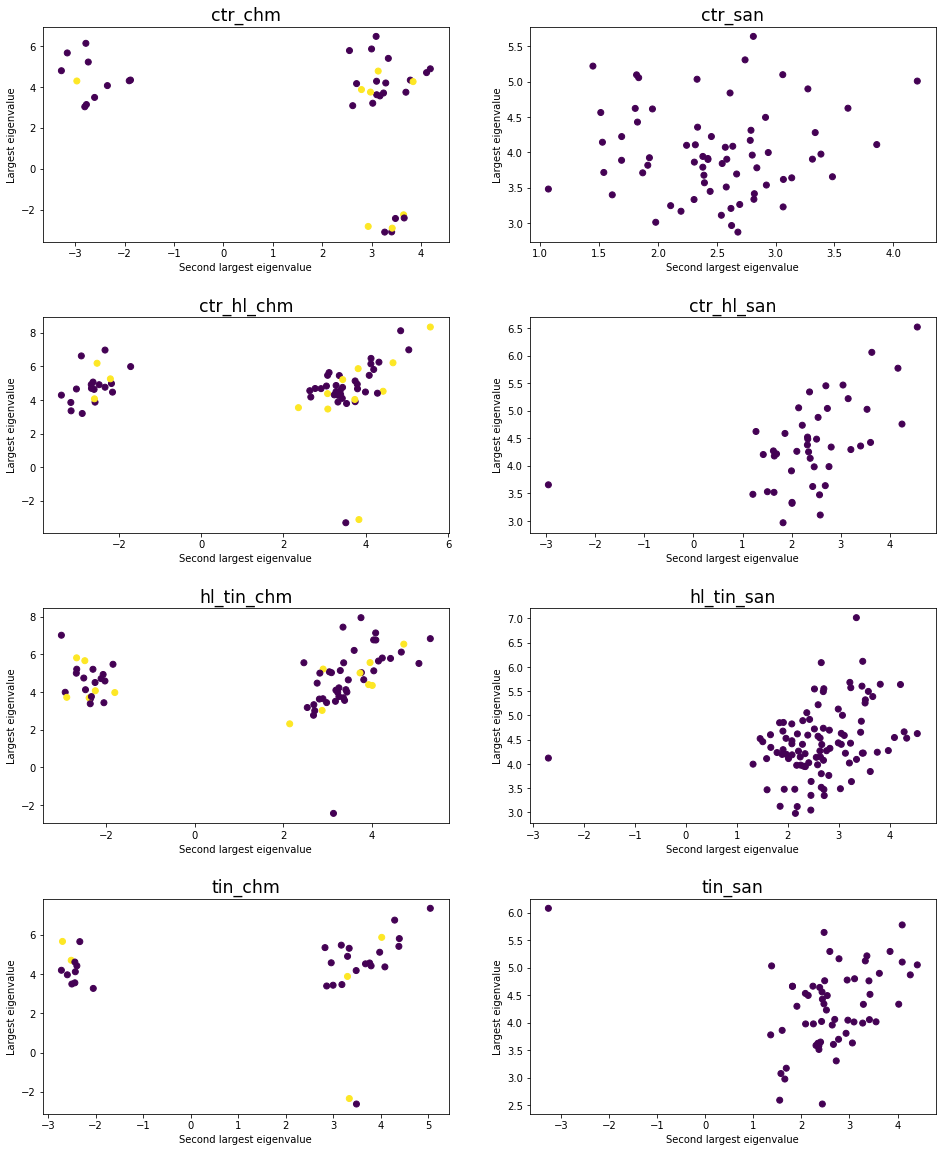

In [177]:
#largest vs second largest
runs = [int(sample['Run'][3]) for sample in data['samples']]
fig,axs = plt.subplots(4,2,figsize=(16,20))
plt.subplots_adjust(hspace=0.35)
for cls,ind_list in enumerate(class_indices):
    #evals are 0-indexed
    which_eval = 0
    largest = []
    second_largest = []
    colors = []
    for i in ind_list:
        evals = linalg.eig(transformed[i])[0]
        if evals[0].real < 100000:
            largest.append(evals[0].real)
            second_largest.append(evals[1].real)
            colors.append(int(runs[i]==3))
    axs[cls//2,cls%2].set_title(class_list[cls],fontsize='xx-large')
    axs[cls//2,cls%2].scatter(second_largest,largest,c=colors)
    #axs[cls//2,cls%2].set_xlim(0,2500)
    #axs[cls//2,cls%2].set_ylim(0,35)
    axs[cls//2,cls%2].set_xlabel('Second largest eigenvalue')
    axs[cls//2,cls%2].set_ylabel('Largest eigenvalue')
plt.savefig('RiemannResults\\compare_largest_evals_riem.png',bbox_inches='tight')

### No

In [178]:
from mpl_toolkits.mplot3d import Axes3D

### Plot largest 3 eigenvalues for each matrix, color code by class

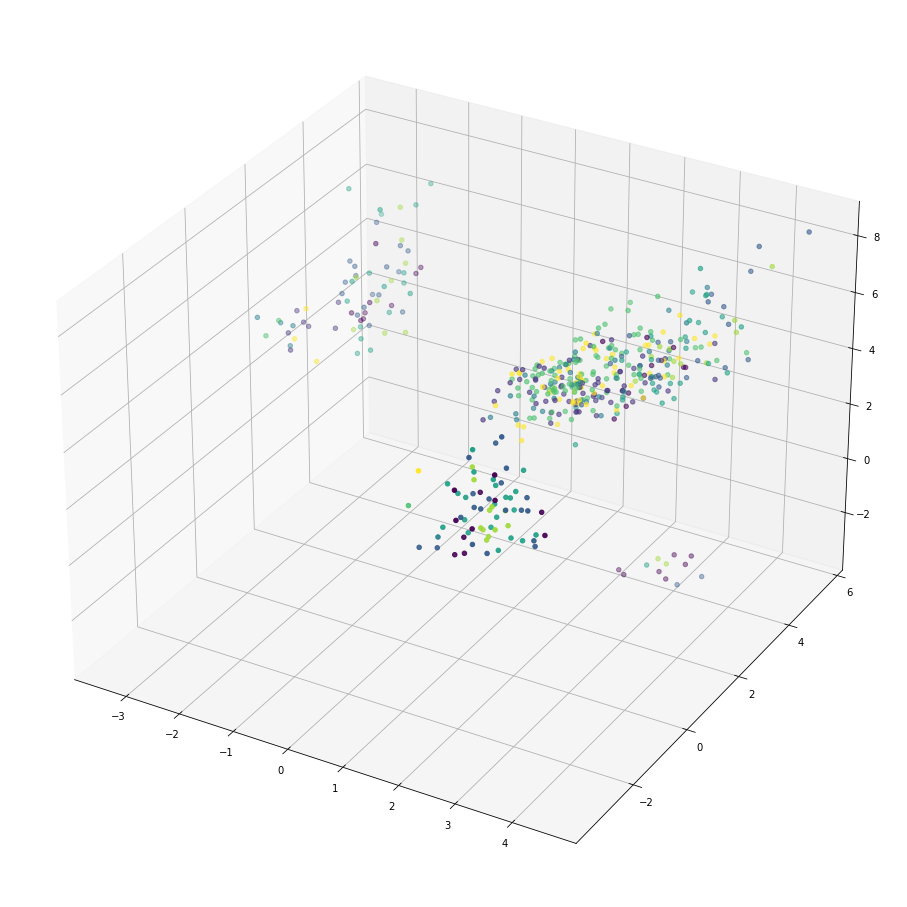

In [179]:
#largest vs second largest
fig,ax = plt.subplots(figsize=(16,20),subplot_kw={'projection':'3d'})
plt.subplots_adjust(hspace=0.35)
colors = []
largest = []
second_largest = []
third_largest = []
for cls,ind_list in enumerate(class_indices):
        for i in ind_list:
            evals = linalg.eig(transformed[i])[0]
            if evals[0].real < 100000:
                largest.append(evals[0].real)
                second_largest.append(evals[1].real)
                third_largest.append(evals[2].real)
                colors.append(cls)
        
ax.scatter(third_largest,second_largest,largest,c=colors)
    

### No obvious separation

### Try to predict TFI with regression

In [180]:
from sklearn.linear_model import LinearRegression, Lasso


In [181]:
x_regr = [mat[np.triu_indices(33,k=1)] for mat in transformed]
y_regr = [x['TFI'] for x in data['samples']]


### Remove controls

In [182]:
non_ctr_inds = [i for i,x in enumerate(y_regr) if x != 0]

In [183]:
x_tin = np.array(x_regr)[non_ctr_inds]
y_tin = np.array(y_regr)[non_ctr_inds]

### Select features with Lasso

In [184]:
Lass = Lasso()
Lass = Lass.fit(x_tin,y_tin)

In [185]:
features = np.argwhere(np.array(Lass.coef_) != 0).flatten().astype(int)

In [186]:
features

array([ 17,  70,  92, 183, 382, 390, 416, 457, 483, 498])

### See what connections these features correspond to

In [187]:
conns = (np.triu_indices(33,k=1)[0][features],np.triu_indices(33,k=1)[1][features])

In [188]:
for i in range(0,len(conns[0])):
    print((rois[conns[0][i]],rois[conns[1][i]]))

('lamygdala', 'ramygdala')
('lcuneus', 'lprimaryvisualcortex')
('lcuneus', 'rventralintraparietalsulcus')
('lmidfrontalgyrus', 'lsuperiortemporalsulcus')
('medialprefrontalcortex', 'rinferiorparietallobe')
('medialprefrontalcortex', 'rsuperiortemporalsulcus')
('precuneus', 'rposteriorintraparietalsulcus')
('rcuneus', 'rprimaryvisualcortex')
('rinferiorparietallobe', 'rmidfrontalgyrus')
('rmidfrontalgyrus', 'rsuperiortemporalsulcus')


In [189]:
x_red = [x[features] for x in x_tin]

In [190]:
LR = LinearRegression()
LR = LR.fit(x_red,y_tin)

In [191]:
LR.score(x_red,y_tin)

0.46971545123950276

### Plot residuals

<AxesSubplot:ylabel='Count'>

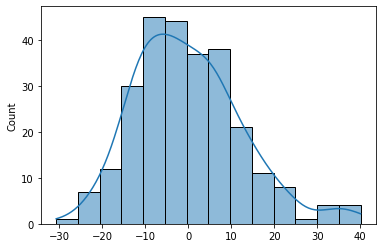

In [192]:
plt.figure()
sn.histplot(y_tin-LR.predict(x_red),kde=True)

Text(0.5, 1.0, 'True vs predicted TFI')

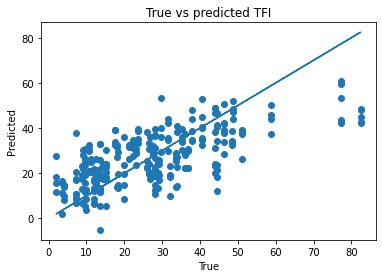

In [193]:
plt.plot(y_tin,y_tin)
plt.scatter(y_tin,LR.predict(x_red))
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs predicted TFI')

### Can we group together individual by their Riemannian feature vectors?
There are a few different ways to test this:
- Tukey honest significant difference test/one-way ANOVA where categorical variable is patient ID
- A bunch of pair-wise t-tests between patients (less conservative than Tukey HSD)

In [194]:
data_df = pd.DataFrame(data['samples'])

In [195]:
data_df.head()

,TimeSeries,Location,Run,ID,Group,TFI
0,"[[389.34, 389.07, 390.5, 390.71, 388.73, 390.3...",chm,run1,117,ctr,0.0
1,"[[389.87, 390.32, 388.74, 387.13, 387.76, 384....",chm,run2,117,ctr,0.0
2,"[[385.1, 386.37, 388.8, 386.77, 386.43, 390.2,...",chm,run3,117,ctr,0.0
3,"[[400.74, 403.26, 402.08, 400.19, 398.39, 399....",chm,run4,117,ctr,0.0
4,"[[413.11, 411.78, 411.5, 410.14, 405.94, 406.4...",chm,run5,117,ctr,0.0


In [196]:
data_df['RiemannFeature'] = x_regr

In [197]:
data_df.head(10)

,TimeSeries,Location,Run,ID,Group,TFI,RiemannFeature
0,"[[389.34, 389.07, 390.5, 390.71, 388.73, 390.3...",chm,run1,117,ctr,0.0,"[-0.39093664861686905, -0.2835431313738902, -0..."
1,"[[389.87, 390.32, 388.74, 387.13, 387.76, 384....",chm,run2,117,ctr,0.0,"[-0.1854559999692926, -0.02327969838321061, -0..."
2,"[[385.1, 386.37, 388.8, 386.77, 386.43, 390.2,...",chm,run3,117,ctr,0.0,"[-0.30558300723210785, -0.03962368839327865, 0..."
3,"[[400.74, 403.26, 402.08, 400.19, 398.39, 399....",chm,run4,117,ctr,0.0,"[0.16486218468365493, -0.05100077574465361, 0...."
4,"[[413.11, 411.78, 411.5, 410.14, 405.94, 406.4...",chm,run5,117,ctr,0.0,"[-0.1804248773356468, -0.3207712982275755, 0.3..."
5,"[[498.21, 497.76, 497.28, 496.18, 496.13, 496....",chm,run1,199,ctr,0.0,"[-0.13586802599228223, -0.10797799777240247, -..."
6,"[[499.7, 501.91, 498.91, 500.39, 499.26, 495.1...",chm,run2,199,ctr,0.0,"[-0.10741090378509259, 0.07619774625480753, 0...."
7,"[[496.31, 495.32, 494.26, 492.7, 496.13, 497.8...",chm,run3,199,ctr,0.0,"[0.07948629959321835, 0.08785914204820951, 0.1..."
8,"[[489.77, 488.35, 485.27, 486.91, 486.39, 486....",chm,run4,199,ctr,0.0,"[-0.12929316979872674, -0.09760559396482499, 0..."
9,"[[490.27, 494.45, 494.27, 490.93, 496.34, 493....",chm,run5,199,ctr,0.0,"[-0.2786700152763864, 0.01857110904459722, 0.1..."


In [198]:
data_df_train = data_df[data_df['Run']=='run1'].reset_index()

In [199]:
data_df_test = data_df[data_df['Run']=='run2'].reset_index()

In [200]:
def get_min_dist(feature):
    return data_df_train.loc[np.argmin([np.linalg.norm(feature - x) for x in data_df_train['RiemannFeature']]),'ID']

In [201]:
data_df_test['NearestNeighbor'] = data_df_test['RiemannFeature'].map(get_min_dist)

In [202]:
data_df_test

,index,TimeSeries,Location,Run,ID,Group,TFI,RiemannFeature,NearestNeighbor
0,1,"[[389.87, 390.32, 388.74, 387.13, 387.76, 384....",chm,run2,117,ctr,0.0,"[-0.1854559999692926, -0.02327969838321061, -0...",117
1,6,"[[499.7, 501.91, 498.91, 500.39, 499.26, 495.1...",chm,run2,199,ctr,0.0,"[-0.10741090378509259, 0.07619774625480753, 0....",199
2,11,"[[493.51, 493.7, 500.12, 498.43, 498.89, 496.6...",chm,run2,200,ctr,0.0,"[-0.00016763923788233595, 0.003973626175697965...",200
3,16,"[[485.67, 490.22, 483.36, 485.61, 491.38, 488....",chm,run2,258,ctr,0.0,"[-0.1934559710115098, -0.059557845129171914, -...",258
4,21,"[[297.21, 297.61, 294.32, 297.81, 297.1, 298.8...",chm,run2,259,ctr,0.0,"[-0.18515828576256957, -0.11776985928565155, -...",259
...,...,...,...,...,...,...,...,...,...
105,456,"[[346.1, 346.85, 348.02, 348.28, 347.35, 346.7...",san,run2,177,tin_hl,13.6,"[0.08592236722089788, -0.038080558179505015, 0...",177
106,460,"[[386.1, 388.8, 391.66, 390.5, 391.44, 390.85,...",san,run2,191,tin_hl,22.4,"[0.11837738963757884, -0.16159736843426079, 0....",191
107,464,"[[445.23, 435.42, 439.18, 437.92, 440.52, 437....",san,run2,197,tin_hl,9.2,"[0.058847024337854575, 0.21994445153639974, -0...",197
108,468,"[[383.59, 377.92, 374.16, 374.95, 379.86, 374....",san,run2,202,tin_hl,7.2,"[-0.5100501890729663, 0.19179075877685833, -0....",202


In [203]:
len(data_df_test[data_df_test['ID'] == data_df_test['NearestNeighbor']])/len(data_df_test)

0.9454545454545454

### So 95% of the time Run2 is correctly identified as the same patient as Run1

In [204]:
train_classifiers.__doc__

"\n    Produces test data and tests whether projecting matrices into the tangent space finds the correct discriminative connection.\n    \n        Parameters:\n            data_files (list of pairs (filename,data)): the input data\n            valid_runs_dict_uiuc (dictionary): dictionary containing valid runs for each patient\n            valid_runs_dict_whasc (dictionary): dictionary containing valid runs for each patient\n            \n        Returns:\n            accDict (dictionary): mean accuracy on each file's data\n            simDict (dictionary): mean cosine similarity of classifier coefficients for each file\n            matDict (dictionary): mean confusion matrix for each file\n            corrDict (dictionary): before and after projection correlations\n            spearDict (dictionary): before and after projection spearman correlations\n    "

In [205]:
dicts = train_classifiers([['raw_data',{'samples':uiuc_samples+whasc_samples}]],valid_runs_dict_uiuc,valid_runs_dict_whasc)

Mean Accuracy w/ Riemann on data raw_data: 0.8791608391608393
Mean Accuracy w/ Cov on data raw_data: 0.5432867132867133
Mean Accuracy w/ RF on data raw_data: 0.6338461538461538
----------------


In [206]:
accDict, corrDict, spearDict, matDict, simDict = dicts

In [207]:
accDict

{'raw_data': {'riem': 0.8791608391608393,
  'rf': 0.6338461538461538,
  'cov': 0.5432867132867133}}

In [208]:
corrDict

{'raw_data': {'before': 445.6539144246622, 'after': 71.90488247196281}}

In [209]:
spearDict

{'raw_data': {'before': 447.65620743075675, 'after': 258.7891035702677}}

In [210]:
simDict

{'raw_data': [0.9419776500892266,
  0.8480440255081217,
  0.9472264075392796,
  0.8868927446489403,
  0.9348197374749824,
  0.872862925281627,
  0.9408748244806956,
  0.9313322006806865,
  0.831819933153468,
  0.9361322922614556,
  0.811351592617717,
  0.9294232026771693,
  0.8005312214269372,
  0.9406708873199302,
  0.8519274866452892,
  0.9190681209245349,
  0.8711753472049572,
  0.9310504271262356,
  0.9430689333600134,
  0.8252330083631806,
  0.9447527722512611,
  0.8232087821155755,
  0.928937550738494,
  0.8647178035983597,
  0.9307538640514801,
  0.9312652707516912,
  0.7849743029031555,
  0.9342512840556199]}

In [211]:
matDict

{'raw_data': array([[9.57272727e-01, 0.00000000e+00, 4.18181818e-02, 0.00000000e+00,
         9.09090909e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.58571429e-01, 0.00000000e+00, 3.33333333e-02,
         0.00000000e+00, 7.23809524e-02, 0.00000000e+00, 3.57142857e-02],
        [4.73684211e-03, 0.00000000e+00, 9.53684211e-01, 0.00000000e+00,
         4.15789474e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.92307692e-02, 0.00000000e+00, 8.11538462e-01,
         0.00000000e+00, 7.92307692e-02, 0.00000000e+00, 4.00000000e-02],
        [2.38095238e-03, 0.00000000e+00, 1.42857143e-02, 0.00000000e+00,
         9.80476190e-01, 0.00000000e+00, 2.85714286e-03, 0.00000000e+00],
        [0.00000000e+00, 4.50000000e-02, 0.00000000e+00, 1.80000000e-02,
         0.00000000e+00, 8.73000000e-01, 0.00000000e+00, 6.40000000e-02],
        [3.10000000e-02, 0.00000000e+00, 2.10000000e-02, 0.00000000e+00,
         5.20000000e-02, 0.000000

Text(0.5, 14.09375, 'predicted label')

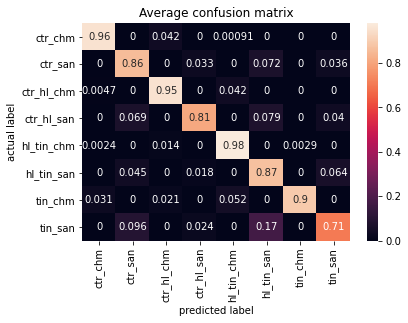

In [212]:
plt.figure()
df_cm = pd.DataFrame(matDict['raw_data'], index = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','hl_tin_chm','hl_tin_san','tin_chm','tin_san'],
                      columns = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','hl_tin_chm','hl_tin_san','tin_chm','tin_san'])

sn.heatmap(df_cm, annot=True)
plt.title("Average confusion matrix")
plt.ylabel('actual label')
plt.xlabel('predicted label')
#plt.savefig('RiemannResults/'+'new_data'+'/AvgConfMat8class.png',bbox_inches='tight')

### Divide by sum along rows to normalize by total predictions in a given class 

Text(0.5, 14.09375, 'predicted label')

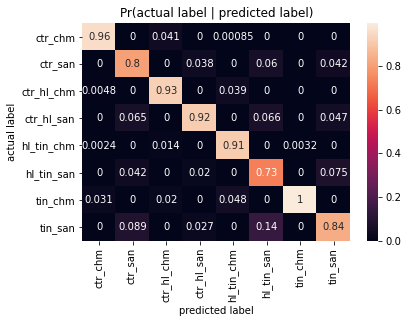

In [213]:
plt.figure()
df_cm = pd.DataFrame(matDict['raw_data']/np.sum(matDict['raw_data'],axis=0), index = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','hl_tin_chm','hl_tin_san','tin_chm','tin_san'],
                  columns = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','hl_tin_chm','hl_tin_san','tin_chm','tin_san'])

sn.heatmap(df_cm, annot=True)
plt.title("Pr(actual label | predicted label)")
plt.ylabel('actual label')
plt.xlabel('predicted label')
#plt.savefig('RiemannResults/'+'new_data'+'/ConditionalAvgConfMat8Class.png',bbox_inches='tight')

### Get discriminative connections

In [214]:
X = np.array([sample['TimeSeries'] for sample in data['samples']])        
y = np.array([get_label_8(sample['Group'],sample['Location']) for sample in data['samples']])

In [215]:
sig_pairs_max, sig_pairs_min = permutation_bootstrap(samples = X, labels = y, n_states = 8, rois=rois, p = 5)

In [216]:
label_list = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','tin_hl_chm','tin_hl_san','tin_chm','tin_san']

In [217]:
import itertools
cmpr_list = list(itertools.combinations(label_list,2))

In [218]:
discrim_dict_max = {cmpr_list[i]: sig_pairs_max[i] for i in range(0,28)}

In [219]:
discrim_dict_max

{('ctr_chm', 'ctr_san'): [],
 ('ctr_chm', 'ctr_hl_chm'): [],
 ('ctr_chm', 'ctr_hl_san'): [],
 ('ctr_chm', 'tin_hl_chm'): [('lcuneus', 'lposteriorintraparietalsulcus'),
  ('lprimaryauditorycortex', 'precuneus'),
  ('rinferiorparietallobe', 'rsuperioroccipitallobe')],
 ('ctr_chm', 'tin_hl_san'): [],
 ('ctr_chm', 'tin_chm'): [],
 ('ctr_chm', 'tin_san'): [],
 ('ctr_san', 'ctr_hl_chm'): [],
 ('ctr_san', 'ctr_hl_san'): [],
 ('ctr_san', 'tin_hl_chm'): [('lanteriorinsula', 'lcuneus')],
 ('ctr_san', 'tin_hl_san'): [('lcuneus', 'lsuperioroccipitallobe')],
 ('ctr_san', 'tin_chm'): [('lsuperiortemporaljunction', 'ramygdala'),
  ('medialprefrontalcortex', 'precuneus')],
 ('ctr_san', 'tin_san'): [],
 ('ctr_hl_chm', 'ctr_hl_san'): [],
 ('ctr_hl_chm', 'tin_hl_chm'): [],
 ('ctr_hl_chm', 'tin_hl_san'): [],
 ('ctr_hl_chm', 'tin_chm'): [],
 ('ctr_hl_chm', 'tin_san'): [],
 ('ctr_hl_san', 'tin_hl_chm'): [('lanteriorinsula', 'lcuneus'),
  ('precuneus', 'rsuperiortemporalsulcus')],
 ('ctr_hl_san', 'tin_hl_san

In [220]:
discrim_dict_min = {cmpr_list[i]: sig_pairs_min[i] for i in range(0,28)}

In [221]:
discrim_dict_min

{('ctr_chm', 'ctr_san'): [('precuneus', 'rfrontaleyefield')],
 ('ctr_chm', 'ctr_hl_chm'): [('lfrontaleyefield', 'linferiorfrontallobe'),
  ('lmidfrontalgyrus', 'lprimaryauditorycortex'),
  ('lposteriorintraparietalsulcus', 'lposteriorintraparietalsulcus')],
 ('ctr_chm', 'ctr_hl_san'): [('precuneus', 'rsuperiortemporalsulcus')],
 ('ctr_chm', 'tin_hl_chm'): [('posteriorcingulatecortex', 'rmidfrontalgyrus')],
 ('ctr_chm', 'tin_hl_san'): [('precuneus', 'rsuperiortemporalsulcus')],
 ('ctr_chm', 'tin_chm'): [('ranteriorinsula', 'rcuneus')],
 ('ctr_chm',
  'tin_san'): [('posteriorcingulatecortex',
   'rsuperiortemporalsulcus'), ('precuneus', 'rfrontaleyefield'), ('precuneus',
   'rsuperiortemporalsulcus')],
 ('ctr_san', 'ctr_hl_chm'): [],
 ('ctr_san',
  'ctr_hl_san'): [('lsuperioroccipitallobe', 'posteriorcingulatecortex')],
 ('ctr_san', 'tin_hl_chm'): [],
 ('ctr_san', 'tin_hl_san'): [],
 ('ctr_san', 'tin_chm'): [],
 ('ctr_san', 'tin_san'): [],
 ('ctr_hl_chm', 'ctr_hl_san'): [('lanteriorinsul

In [ ]:
barheights = [[x for x in valdict.values()] for filename,valdict in accDict.items()] 

In [ ]:
bheights = np.array(barheights).T

In [ ]:
color = ['red','green','blue']

In [ ]:
keys = list(x.rstrip('tv_linear') for x in accDict.keys())

In [ ]:
matplotlib.rcParams.update({'font.size': 40})
fig,ax = plt.subplots(figsize=(12,12))
ax.set_ylim(0,1.2)
ax.grid(True)
for i,filebar in enumerate(bheights):
    ax.bar([i/3+2*j for j,_ in enumerate(bheights[0])],filebar,color = color[i], 
           width = 1/3,tick_label = keys)
plt.xticks([1/3+2*j for j in range(0,len(accDict))], rotation=45)
plt.legend(['Riemann SVM','Random Forest','Plain SVM'])
plt.ylabel('Accuracy')
plt.title('Classifier Accuracies')
dx = -60/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
#plt.savefig('RiemannResults/Graphs/ClassAcc.png',bbox_inches='tight')